# Input first 5 paragraphs of news articles into the IST-195 data store

In [1]:
import json
import requests

In [2]:
# Create the repository
response = requests.post('http://127.0.0.1:5000/dna/v1/repositories?repository=ist-195')
print(response.status_code, response.json()) 
response = requests.get('http://127.0.0.1:5000/dna/v1/repositories')
print(response.status_code, response.json()) 

201 {'created': 'ist-195'}
200 [{'created': '2022-10-01T20:06:39', 'repository': 'ist-195'}]


In [3]:
# Simulate getting the meta-data for news using a pre-selected list and news API service
# Or the meta-data may be added by hand or missing altogether except for a title
LC_FarRight_meta = {
            "author": "Jordan Dixon-Hamilton",
            "published": "2022-08-16T00:00:00",
            "publisher": "Breitbart",
            "source": "https://www.breitbart.com/politics/2022/08/16/liz-cheney-compares-herself-abraham-lincoln-concession-speech/",
            "title": "Liz Cheney Compares Herself to Abraham Lincoln in Concession Speech"}
LC_Right_meta = {
            "author": "Brandon Gillespie",
            "published": "2022-08-16T00:00:00",
            "publisher": "Fox News",
            "source": "https://www.foxnews.com/politics/liz-cheney-compares-herself-abraham-lincoln-resounding-defeat-wyoming-primary", 
            "title": "Rep. Liz Cheney compares herself to Abraham Lincoln following resounding defeat in Wyoming primary"}
LC_Center_meta = {
            "author": "Natalie Andrews",
            "published": "2022-08-17T00:00:00",
            "publisher": "Wall Street Journal",
            "source": "https://www.wsj.com/articles/liz-cheney-faces-uphill-fight-in-primary-against-trump-backed-opponent-11660642201", 
            "title": "Liz Cheney Concedes to Trump-Backed Challenger in Wyoming Primary"}
LC_Left_meta = {
            "author": "Maggie Astor",
            "published": "2022-08-17T00:00:00",
            "publisher": "New York Times",
            "source": "https://www.nytimes.com/2022/08/17/us/politics/liz-cheney-concession-speech.html", 
            "title": "Liz Cheney Invokes Lincoln and Grant in Impassioned Concession Speech"}
meta_array = [LC_FarRight_meta, LC_Right_meta, LC_Center_meta, LC_Left_meta]

In [4]:
index = 0
for file_name in ('LC-FarRight', 'LC-Right', 'LC-Center', 'LC-Left'):
    with open('LC-FarRight.txt', 'r') as inf:
        news_text = inf.read()    
    req_dict = {"narrativeMetadata" : meta_array[index],
                "narrative": news_text}
    index += 1
    response = requests.post('http://127.0.0.1:5000/dna/v1/repositories/narratives?repository=ist-195&extSources=true',
                             json=req_dict)
    print(response.status_code, response.json())
   

201 {'narrativeId': '465bf7f1', 'narrativeMetadata': {'author': 'Jordan Dixon-Hamilton', 'published': '2022-08-16T00:00:00', 'publisher': 'Breitbart', 'source': 'https://www.breitbart.com/politics/2022/08/16/liz-cheney-compares-herself-abraham-lincoln-concession-speech/', 'title': 'Liz Cheney Compares Herself to Abraham Lincoln in Concession Speech'}, 'numberOfTriples': '204', 'processed': '2022-10-01T20:08:10', 'repository': 'ist-195'}
201 {'narrativeId': '399b2dc8', 'narrativeMetadata': {'author': 'Brandon Gillespie', 'published': '2022-08-16T00:00:00', 'publisher': 'Fox News', 'source': 'https://www.foxnews.com/politics/liz-cheney-compares-herself-abraham-lincoln-resounding-defeat-wyoming-primary', 'title': 'Rep. Liz Cheney compares herself to Abraham Lincoln following resounding defeat in Wyoming primary'}, 'numberOfTriples': '204', 'processed': '2022-10-01T20:08:28', 'repository': 'ist-195'}
201 {'narrativeId': '5cea66b1', 'narrativeMetadata': {'author': 'Natalie Andrews', 'publis

# Demo Outputs

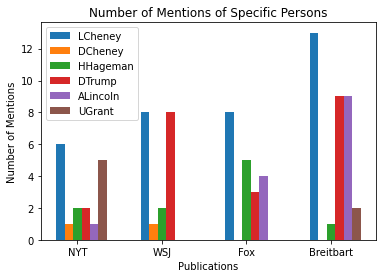

In [14]:
# Display a table of people and counts of their occurrences in the narratives
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy

pubs = ['NYT', 'WSJ', 'Fox', 'Breitbart']
liz_cheney = [6, 8, 8, 13] 
dick_cheney = [1, 1, 0, 0]  
harriet_hageman = [2, 2, 5, 1]
donald_trump = [2, 8, 3, 9]
abraham_lincoln = [1, 0, 4, 9]
ulysses_grant = [5, 0, 0, 2]

X_axis = np.arange(len(pubs))
plt.bar(X_axis - 0.2, liz_cheney, 0.1, label = 'LCheney')
plt.bar(X_axis - 0.1, dick_cheney, 0.1, label = 'DCheney')
plt.bar(X_axis, harriet_hageman, 0.1, label = 'HHageman')
plt.bar(X_axis + 0.1, donald_trump, 0.1, label = 'DTrump')
plt.bar(X_axis + 0.2, abraham_lincoln, 0.1, label = 'ALincoln')
plt.bar(X_axis + 0.3, ulysses_grant, 0.1, label = 'UGrant')
  
plt.xticks(X_axis, pubs)
plt.xlabel("Publications")
plt.ylabel("Number of Mentions")
plt.title("Number of Mentions of Specific Persons")
plt.legend()
plt.show()


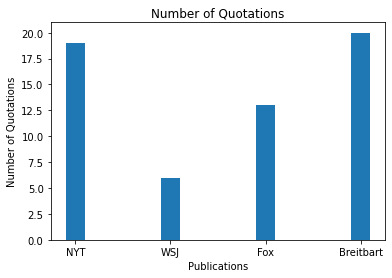

In [16]:
X_axis = np.arange(len(pubs))
plt.bar(X_axis, [19, 6, 13, 20], 0.2)
  
plt.xticks(X_axis, pubs)
plt.xlabel("Publications")
plt.ylabel("Number of Quotations")
plt.title("Number of Quotations")
plt.show()


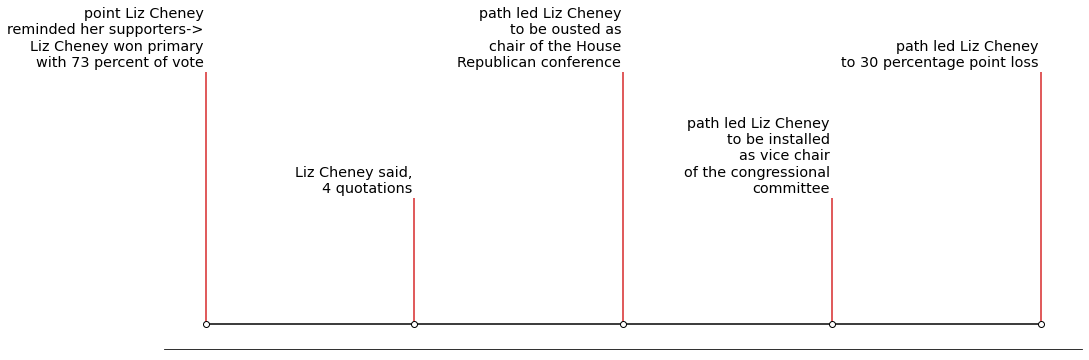

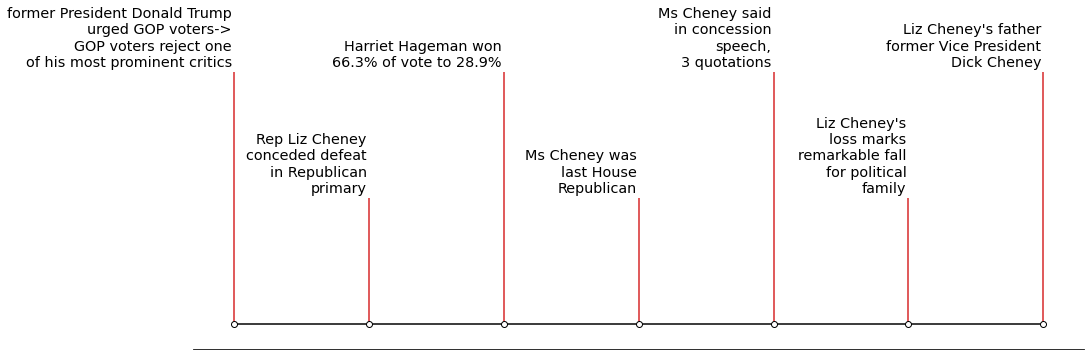

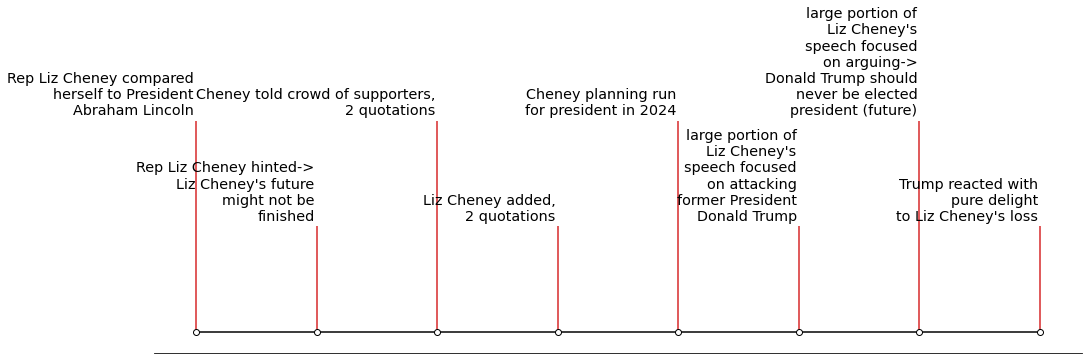

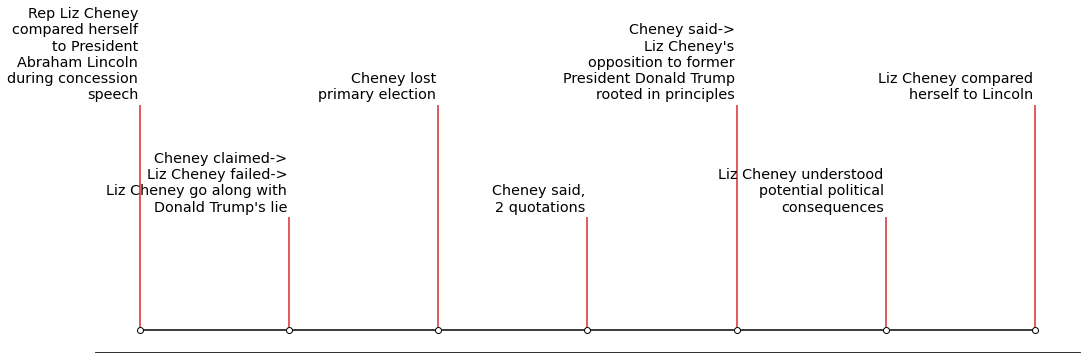

In [66]:
nyt_events = ["point Liz Cheney\nreminded her supporters->\nLiz Cheney won primary\nwith 73 percent of vote",
              "Liz Cheney said,\n4 quotations", 
              "path led Liz Cheney\nto be ousted as\nchair of the House\nRepublican conference",
              "path led Liz Cheney\nto be installed\nas vice chair\nof the congressional\ncommittee", 
              "path led Liz Cheney\nto 30 percentage point loss"]
wsj_events = ["former President Donald Trump\nurged GOP voters->\nGOP voters reject one\nof his most prominent critics",
              "Rep Liz Cheney\nconceded defeat\nin Republican\nprimary", 
              "Harriet Hageman won\n66.3% of vote to 28.9%", "Ms Cheney was\nlast House\nRepublican",
              "Ms Cheney said\nin concession\nspeech,\n3 quotations",
              "Liz Cheney's\nloss marks\nremarkable fall\nfor political\nfamily",
              "Liz Cheney's father\nformer Vice President\nDick Cheney"]
fox_events = ["Rep Liz Cheney compared\nherself to President\nAbraham Lincoln", 
              "Rep Liz Cheney hinted->\nLiz Cheney's future\nmight not be\nfinished", 
              "Cheney told crowd of supporters,\n2 quotations",
              "Liz Cheney added,\n2 quotations", "Cheney planning run\nfor president in 2024", 
              "large portion of\nLiz Cheney's\nspeech focused\non attacking\nformer President\nDonald Trump",
              "large portion of\nLiz Cheney's\nspeech focused\non arguing->\nDonald Trump should\nnever be elected\npresident (future)", 
              "Trump reacted with\npure delight\nto Liz Cheney's loss"]
breitbart_events = ["Rep Liz Cheney\ncompared herself\nto President\nAbraham Lincoln\nduring concession\nspeech",
                    "Cheney claimed->\nLiz Cheney failed->\nLiz Cheney go along with\nDonald Trump's lie", 
                    "Cheney lost\nprimary election", "Cheney said,\n2 quotations", 
                    "Cheney said->\nLiz Cheney's\nopposition to former\nPresident Donald Trump\nrooted in principles", 
                    "Liz Cheney understood\npotential political\nconsequences",
                    "Liz Cheney compared\nherself to Lincoln"]

for i in range(4):
    # For matplotlib timeline, need datetime formatting
    if i == 0:
        title = 'NYT Article'
        events = nyt_events
    elif i == 1:
        title = 'WSJ Article'
        events = wsj_events
    elif i == 2:
        title = 'Fox Article'
        events = fox_events
    elif i == 3:
        title = 'Breitbart Article'
        events = breitbart_events
    plot_dates = np.arange(len(events))
    # Create a stem plot with some variation in levels as to distinguish close-by events.
    # Add markers on the baseline with dates
    # For each event, add a text label via annotate, which is offset from the tip of the event line
    levels = np.tile([2, 1, 2, 1, 2, 1, 2, 1, 2],
                     int(np.ceil(len(plot_dates) / 6)))[:len(plot_dates)]
    # Create figure and plot a stem plot with the dates
    fig, ax = plt.subplots()
    dpi = fig.get_dpi()
    fig.set_size_inches(15, 5)
    ax.vlines(plot_dates, 0, levels, color="tab:red")  # The vertical stems
    ax.plot(plot_dates, np.zeros_like(plot_dates), "-o",
            color="k", markerfacecolor="w")  # Baseline and markers on it
    # Annotate lines
    for d, l, r in zip(plot_dates, levels, events):
        ax.annotate(r, xy=(d, l),
                    xytext=(-2, np.sign(l) * 3), textcoords="offset points",
                    horizontalalignment="right",
                    verticalalignment="bottom" if l > 0 else "top", fontsize='x-large')
    # Format x-axis with yearly intervals
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize='medium')
    # Remove x- and y-axis and spines
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)
    ax.margins(y=0.1)
    plt.tight_layout(pad=0.05, h_pad=0.05, w_pad=0.05)
    plt.show()

In [46]:
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections

In [ ]:
# Eigenvector centrality -- mean and stdev
ec = nx.eigenvector_centrality(G)
degrees = []
for k,v in ec.items():
    degrees.append(v)
    
print("EIGENVECTOR CENTRALITY")
print("======================")
print("The mean network eigenvector centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(ec, key=ec.get), max(ec.values())))
print("The minimum node is {}, with value {}".format(min(ec, key=ec.get), min(ec.values())))
histogram(ec)
print()

# Betweenness centrality -- mean and stdev
bc = nx.betweenness_centrality(G)
degrees = []
for k,v in bc.items():
    degrees.append(v)
print("BETWEENNESS CENTRALITY")
print("======================")
print("The mean betwenness centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(bc, key=bc.get), max(bc.values())))
print("The minimum node is {}, with value {}".format(min(bc, key=bc.get), min(bc.values())))
histogram(bc)
print()
    
# Plot
print("Visualizing the graph:")
plt.plot()
nx.draw(G, with_labels=True, font_weight='bold')

In [50]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def number_of_pendants(g):
    """
    Equals the number of nodes with degree 1
    """
    pendants = 0
    for u in g:
        if g.degree[u] == 1:
            pendants += 1
    return pendants


def histogram(l):
    degree_sequence = sorted([d for n, d in list(l.items())], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    print(deg, cnt)
    
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histogram")
    plt.ylabel("Count")
    plt.xlabel("Value")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

LC-Left-Final.ttl
rdflib Graph loaded successfully with 105 triples
networkx Graph loaded successfully with length 93
NETWORK SIZE
The network has 93 nodes and 101 edges

PENDANTS/Nodes with degree 1
The network has 60 pendants

DENSITY
The network density is 0.023609163160355308

DEGREE CENTRALITY
The mean degree centrality is 0.023609163160355297, with stdev 0.02320349485944098
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.10869565217391304
The minimum node is The path was clear, with value 0.010869565217391304
(0.10869565217391304, 0.09782608695652173, 0.08695652173913043, 0.06521739130434782, 0.05434782608695652, 0.043478260869565216, 0.03260869565217391, 0.021739130434782608, 0.010869565217391304) (1, 2, 2, 6, 1, 4, 7, 10, 60)


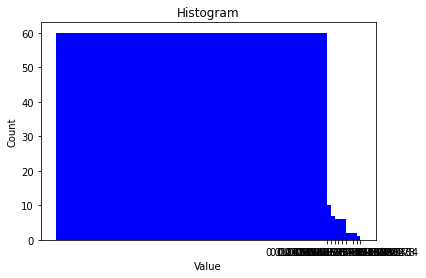


CONNECTED COMPONENTS
The graph has 2 connected components
Connected component 0 has 90 nodes
Connected component 1 has 3 nodes

LC-Center-Final.ttl
rdflib Graph loaded successfully with 116 triples
networkx Graph loaded successfully with length 102
NETWORK SIZE
The network has 102 nodes and 111 edges

PENDANTS/Nodes with degree 1
The network has 66 pendants

DENSITY
The network density is 0.021549213744903904

DEGREE CENTRALITY
The mean degree centrality is 0.021549213744903914, with stdev 0.02110283386856961
The maximum node is urn:ontoinsights:dna:Event_f5bec324-e90a, with value 0.09900990099009901
The minimum node is urn:ontoinsights:dna:PiT_Tuesday, with value 0.009900990099009901
(0.09900990099009901, 0.0891089108910891, 0.07920792079207921, 0.06930693069306931, 0.0594059405940594, 0.04950495049504951, 0.039603960396039604, 0.0297029702970297, 0.019801980198019802, 0.009900990099009901) (1, 2, 1, 4, 3, 4, 1, 10, 10, 66)


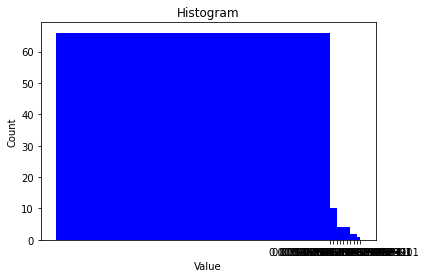


CONNECTED COMPONENTS
The graph has 3 connected components
Connected component 0 has 92 nodes
Connected component 1 has 3 nodes
Connected component 2 has 7 nodes

LC-Right-Final.ttl
rdflib Graph loaded successfully with 138 triples
networkx Graph loaded successfully with length 113
NETWORK SIZE
The network has 113 nodes and 131 edges

PENDANTS/Nodes with degree 1
The network has 74 pendants

DENSITY
The network density is 0.020701643489254108

DEGREE CENTRALITY
The mean degree centrality is 0.020701643489254157, with stdev 0.021879082772030923
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.10714285714285714
The minimum node is urn:ontoinsights:dna:AssessmentAndCharacterization, with value 0.008928571428571428
(0.10714285714285714, 0.09821428571428571, 0.08035714285714285, 0.07142857142857142, 0.0625, 0.05357142857142857, 0.04464285714285714, 0.03571428571428571, 0.026785714285714284, 0.017857142857142856, 0.008928571428571428) (1, 1, 2, 5, 2, 4, 1, 5, 8, 10, 74)


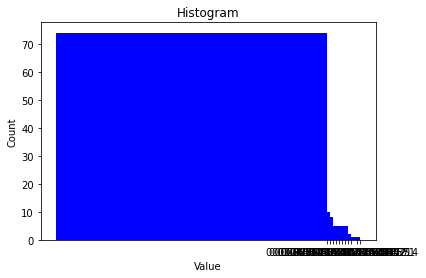


CONNECTED COMPONENTS
The graph has 6 connected components
Connected component 0 has 99 nodes
Connected component 1 has 4 nodes
Connected component 2 has 3 nodes
Connected component 3 has 3 nodes
Connected component 4 has 2 nodes
Connected component 5 has 2 nodes

LC-FarRight-Final.ttl
rdflib Graph loaded successfully with 104 triples
networkx Graph loaded successfully with length 82
NETWORK SIZE
The network has 82 nodes and 98 edges

PENDANTS/Nodes with degree 1
The network has 52 pendants

DENSITY
The network density is 0.029509183980728697

DEGREE CENTRALITY
The mean degree centrality is 0.02950918398072873, with stdev 0.03381037376815727
The maximum node is urn:ontoinsights:dna:Event_23f401c8-fd1c, with value 0.18518518518518517
The minimum node is From Wikipedia (wikibase_item: Q91): 'Abraham Lincoln was an American lawyer and statesman who served as the 16th president of the United States from 1861 until his assassination in 1865. Lincoln led the nation through the American Civil

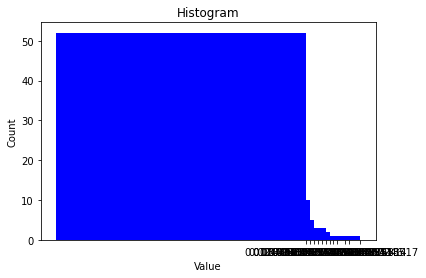


CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 82 nodes



In [57]:
for i in range(4):
    # For matplotlib timeline, need datetime formatting
    if i == 0:
        title = 'LC-Left-Final.ttl'
    elif i == 1:
        title = 'LC-Center-Final.ttl'
    elif i == 2:
        title = 'LC-Right-Final.ttl'
    elif i == 3:
        title = 'LC-FarRight-Final.ttl'
    print(title)
    rg = RDFGraph()
    rg.parse(title, format='turtle')
    print("rdflib Graph loaded successfully with {} triples".format(len(rg)))
    G = rdflib_to_networkx_graph(rg)
    print("networkx Graph loaded successfully with length {}".format(len(G)))
    
    # Network size
    print("NETWORK SIZE")
    print("============")
    print("The network has {} nodes and {} edges".format(G.number_of_nodes(), G.number_of_edges()))
    print()

    # Network size
    print("PENDANTS/Nodes with degree 1")
    print("============")
    print("The network has {} pendants".format(number_of_pendants(G)))
    print()

    # Density
    print("DENSITY")
    print("============")
    print("The network density is {}".format(nx.density(G)))
    print()

    # Degree centrality -- mean and stdev
    dc = nx.degree_centrality(G)
    degrees = []
    for k,v in dc.items():
        degrees.append(v)

    print("DEGREE CENTRALITY")
    print("=================")
    print("The mean degree centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(dc, key=dc.get), max(dc.values())))
    print("The minimum node is {}, with value {}".format(min(dc, key=dc.get), min(dc.values())))
    histogram(dc)
    print()

    # Connected components
    cc = list(nx.connected_components(G))
    print("CONNECTED COMPONENTS")
    print("====================")
    print("The graph has {} connected components".format(len(cc)))
    for i,c in enumerate(cc):
        print("Connected component {} has {} nodes".format(i,len(c)))
    print()